# Dog breed classifier using Convolutional Neural Networks

This notebook is an example of using CNN and learning transfer to detect the breed of the dog in an image.
I have used Pythorch deep learning framework. As the initial pretrained model I have used ResNet-34.
The images for training are here  [dog dataset](https://www.kaggle.com/c/dog-breed-identification/data)

In [1]:
import os
from glob import glob
from PIL import ImageFile, Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F
from torch import nn, optim
import torchvision
from torchvision import models, transforms, datasets

import warnings
warnings.filterwarnings("ignore")

# VC: Allow truncated images.
ImageFile.LOAD_TRUNCATED_IMAGES = True

%matplotlib inline


### Training the Model

The following function implements the training loop. It uses the mini-batch gradient descent method.

In [2]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, 
          noise_factor=0, valid_loss_min = np.Inf, modelToSave = None):
    """returns the trained model"""

    for epoch in range(1, n_epochs+1):
        # initialize variables used to monitor the training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        # train the model #
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            data = data + noise_factor * torch.randn(*data.shape)
            # move the data and the target to GPU if it is available
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # get the loss and update the model parameters to minimize the loss
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            #compute the average training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

        # validate the model #
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move the data and the target to GPU if it is available
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # update the average validation loss value
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print the training/validation 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        # Saving the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Validation loss has decreases from {:.6f} to {:.6f}, saving the model...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
            # Choosing to save the entire model or only part of it if specified
            if modelToSave is not None:
                torch.save(modelToSave.state_dict(), save_path)
            else:
                torch.save(model.state_dict(), save_path)
            
    # return the trained model
    return model


### Testing the Model

This function is implementing the testing of the model. It uses the test dataset to asses the accuracy of the predictions. 

In [3]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move the data and target to GPU if GPU is available
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # compute the predicted outputs
        output = model(data)
        # calculate the loss value
        loss = criterion(output, target)
        # update average test loss value 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert the output probabilities to the predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare the predictions to the true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


### Specifying the Data Loaders for the Dog Dataset

In [4]:
batch_size = 20
num_workers = 0
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])
preprocess = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224),
                                transforms.ToTensor(), normalize])

transfer_train_set = datasets.ImageFolder('dogImages/train', transform=preprocess)
transfer_test_set = datasets.ImageFolder('dogImages/test', transform=preprocess)
transfer_valid_set = datasets.ImageFolder('dogImages/valid', transform=preprocess)

transfer_train_loader = torch.utils.data.DataLoader(transfer_train_set, batch_size=batch_size,
                                                   shuffle = True, num_workers = num_workers)
transfer_test_loader = torch.utils.data.DataLoader(transfer_test_set, batch_size=batch_size,
                                                   shuffle = True, num_workers = num_workers)
transfer_valid_loader = torch.utils.data.DataLoader(transfer_train_set, batch_size=batch_size,
                                                   shuffle = True, num_workers = num_workers)
loaders_transfer = {'train':transfer_train_loader, 
                   'test':transfer_test_loader, 
                   'valid':transfer_valid_loader}

# list of class names
class_names = [item[4:].replace("_", " ") for item in transfer_train_set.classes]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

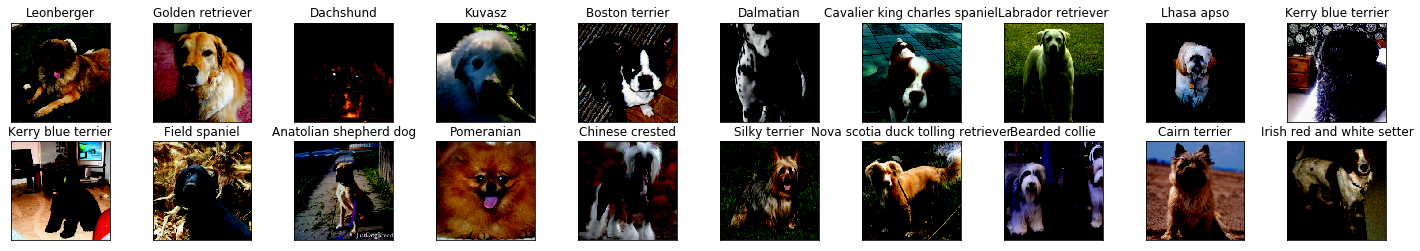

In [5]:
### VC: this function is used to show the images from the training loader to 
### check that there are no issues in the data structure and the loaders
def show_samples(train_loader):
    images, labels = next(iter(transfer_train_loader))
    imgs = images.numpy()

    fig = plt.figure(figsize = (25,4))
    for idx in range(20):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(imgs[idx], (1, 2, 0)))
        ax.set_title(class_names[labels[idx]])
        
show_samples(transfer_train_loader)

### Model Architecture

I am using here transfer learning to create a CNN to classify dog breed. First I am initializing the pretrained ResNet34 model and freezing the parameters to not change the weights during the training.
I change the last linear layer to classify the breeds. There are 133 breeds in the dataset so it is needed to change the size of the model output from 500 to 133.

In [7]:
model_transfer = models.resnet34(pretrained=True)
for param in model_transfer.parameters():
    param.requires_grad = False
    
model_transfer.fc = nn.Linear(model_transfer.fc.in_features, len(transfer_train_set.classes))

if torch.cuda.is_available():
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ec2-user/.cache/torch/checkpoints/resnet34-333f7ec4.pth


### Specifying the Loss Function and Optimizer

In [7]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = torch.optim.SGD(model_transfer.fc.parameters(), lr=0.001)

### Training and Validating the Model

If the previously trained model was saved then we can load the parameters from the file model.pt to continue the training process. Because I am training only the last liniear layer, I save and load only the last layer of ResNet34 architecture. 

In [8]:
if os.path.exists('model.pt'):
    model_transfer.fc.load_state_dict(torch.load('model.pt', map_location=lambda storage, loc: storage))

model_transfer = train(20, loaders_transfer, model_transfer, 
                       optimizer_transfer, criterion_transfer, 
                       torch.cuda.is_available(), 'model.pt', 
                       modelToSave = model_transfer.fc)

Epoch: 1 	Training Loss: 4.893950 	Validation Loss: 4.657000
Validation loss has decreases from inf to 4.657000, saving the model...
Epoch: 2 	Training Loss: 4.526349 	Validation Loss: 4.306952
Validation loss has decreases from 4.657000 to 4.306952, saving the model...
Epoch: 3 	Training Loss: 4.221068 	Validation Loss: 3.980415
Validation loss has decreases from 4.306952 to 3.980415, saving the model...
Epoch: 4 	Training Loss: 3.936791 	Validation Loss: 3.694401
Validation loss has decreases from 3.980415 to 3.694401, saving the model...
Epoch: 5 	Training Loss: 3.681923 	Validation Loss: 3.417016
Validation loss has decreases from 3.694401 to 3.417016, saving the model...
Epoch: 6 	Training Loss: 3.434834 	Validation Loss: 3.156689
Validation loss has decreases from 3.417016 to 3.156689, saving the model...
Epoch: 7 	Training Loss: 3.208310 	Validation Loss: 2.920481
Validation loss has decreases from 3.156689 to 2.920481, saving the model...
Epoch: 8 	Training Loss: 3.006677 	Vali

### Testing the Model

Here I call the test function passing the testing dataset and the trained model. I have trained the model for 20 epochs on batchs of size 20. The achieved accuracy is quite good for 20 epochs but can be improved by continuing the training process. 

In [9]:
test(loaders_transfer, model_transfer, criterion_transfer, torch.cuda.is_available())

Test Loss: 1.479469


Test Accuracy: 74% (624/836)


### Predicticting the Dog Breed with the Model

Next, I implement the functions that can be used to apply the model to predict the breeds using images not from the training dataset. The function predict_breed_transfer takes as parameter the path to an image and it returns the class (dog breed name) and the probability value that the dog is of that breed.

In [5]:
### VC: this function retreives the resnet34 pretraned model replace the last layer  
### with the one that classifies the breed and then load the state_dict from model.pt file
def init_transfer_model():
    model = models.resnet34(pretrained=True)
    model.fc = torch.nn.Linear(model.fc.in_features, len(transfer_train_set.classes))
    transfer_dict = torch.load('model.pt', map_location=lambda storage, location:storage)
    model.fc.load_state_dict(transfer_dict)
    model.eval()
    if torch.cuda.is_available():
        model.cuda()
    return model

### VC: this function is the task implementation that 
### returns the class name of the bread and the probability.
def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    image = Image.open(img_path).convert('RGB')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    preprocess = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224),
                                    transforms.ToTensor(), normalize])
    image = preprocess(image).unsqueeze(0)
    if torch.cuda.is_available():
        image = image.cuda()
    
    transfer_model = init_transfer_model()
    output = transfer_model(image)
    pred = torch.max(output, 1)[1]
    pred = pred.cpu() if torch.cuda.is_available() else pred
    
    prob = torch.max(F.softmax(output, dim=1), 1)[0]
    prob = prob.cpu() if torch.cuda.is_available() else prob
    
    return class_names[pred.item()], prob.item()

In [6]:
### VC: this function is used to load and image from the disk 
### and return a tensor
def load_image(image_file):
    img = Image.open(image_file).convert('RGB')
    image_transform = transforms.Compose([transforms.Resize(224),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor()])
    return image_transform(img).unsqueeze(0)

### VC: this function is used to show an image tensor
def show_image(image, title=None):
    image = image.numpy().squeeze()
    fig = plt.figure(figsize = (4,4))
    #text = fig.text(0.5, 0.5, title, va='center', size=20)
    ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
    ax.set_title(title, fontsize='x-large')
    plt.imshow(np.transpose(image, (1, 2, 0)))

In [8]:
if os.path.exists('model.pt'):
    model_transfer.fc.load_state_dict(torch.load('model.pt', map_location=lambda storage, loc: storage))

### The function that classifies the image
As a result of many experiments I have chosen the probability threshold of 0.2 to decide that there is a dog of the classified breed or no dog at all in the image.

In [19]:
def run_app(img_path):
    breed, breed_certainty = predict_breed_transfer(img_path)
    if breed_certainty > 0.2:
        title = 'Hello Doggy!\n'+'You are {}'.format(breed)
        image = load_image(img_path)
        show_image(image,title)
    else:
        image = load_image(img_path)
        show_image(image,'Sorry but there is no dog in the image :(')


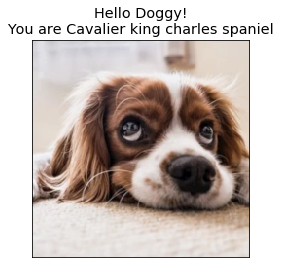

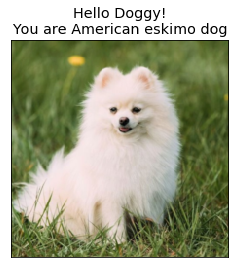

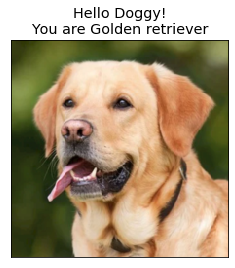

In [20]:
images = np.array(glob('images/*'))
for image in images:
    run_app(image)